# Compute foraging behavior
### a) Validate with proteomics
### b) Inverse: estimate environment probabilities from foraging proteomics/transcriptome

### Forward
$$
\begin{align}
\max_{v^k,e}  \quad & f^T e + \sum_k p^k (c^T v^k) \\
\mathrm{s.t.} \quad & S^k v^k = 0 \\
                    & \sum_j e_j \leq P \\
                    & \sum_j e^k_j \leq P^k \\
                    & e^k_j = e_j + \delta_j^k \\
                    & v^k_j \leq k^\mathrm{eff}_j \cdot e_j \\
                    & l^k \leq v^k \leq u^k \\
                    & e \geq 0
\end{align}
$$

## With expression deviation constraints/objective

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [2]:
from dynamicme.optimize import StackOptimizer

In [3]:
#mdl0 = load_json_model('/home/laurence/ME/models/e_coli_core_mm.json')
mdl0 = load_json_model('/home/laurence/ME/models/ijomm_protmass.json')
crowd0 = mdl0.metabolites.crowding

## Measured

In [4]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')
ex_rxns = [r for r in df_meas.ex_rxn.unique() if mdl0.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]

## Environment probabilities

In [5]:
# Uniform
import json
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/cnps_conds.json') as f:
    cnps = json.load(f)
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/media_exchanges.json') as f:
    cnps_rxns = json.load(f)

In [6]:
conds = cnps['C']

In [7]:
rows = []
for csrc in conds:
    ex_rxn = cnps_rxns[csrc]
    if mdl0.reactions.has_id(ex_rxn):
        # Reset all other ex rxns to zero
        for csrcj in cnps['C']:
            ex_rxnj = cnps_rxns[csrcj]
            if mdl0.reactions.has_id(ex_rxnj):
                rows.append({'cond':csrc, 'rxn':ex_rxnj, 'lb':0., 'ub':1000., 'obj':0.})
        if csrc=='Acetate':
            lb = -20.
        else:
            lb = -10.
        if mdl0.reactions.has_id(ex_rxn):
            rows.append({'cond':csrc, 'rxn':ex_rxn, 'lb':lb, 'ub':1000., 'obj':0.})

In [8]:
df_conds = pd.DataFrame(rows)
df_X = df_conds
conds = df_X.cond.unique()

df_X_ex = df_X[ df_X.lb<0][['cond','rxn']].drop_duplicates()
df_X_ex.rename(columns={'rxn':'ex_rxn'}, inplace=True)
df_X  = pd.merge(df_X, df_X_ex, on='cond')

## Keep only subset of conds for now
df_XY = pd.merge(df_X, df_meas, on='ex_rxn')
conds = df_XY.cond.unique()
df_X  = df_X[ df_X.cond.isin(conds)]

In [9]:
df_XY[['cond','ex_rxn','substrate','growth_rate_1_h']].drop_duplicates()

,cond,ex_rxn,substrate,growth_rate_1_h
0,Acetate,EX_ac_e,acetate,0.256
179,D-Fructose,EX_fru_e,fructose,0.550
358,D-Galactose,EX_gal_e,galactose,0.520
537,D-Glucose,EX_glc__D_e,glucose,0.740
716,D-Mannose,EX_man_e,mannose,0.560
895,Glycerol,EX_glyc_e,glycerol,0.420
1074,L-Lactate,EX_lac__L_e,lactate,0.390
1253,L-Malate,EX_mal__L_e,malate,0.440
1432,Maltose,EX_malt_e,maltose,0.620
1611,Succinate,EX_succ_e,succinate,0.460


In [10]:
print(len(conds))

10


## Drop infeasible conds

In [11]:
stat_dict = {}
for cond in conds:
    dfi = df_conds[ df_conds.cond==cond]
    for i,row in dfi.iterrows():
        rid = row['rxn']
        rxn = mdl0.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    mdl0.optimize(solver='gurobi')
    stat_dict[cond] = mdl0.solution.status

In [12]:
for ind,stat in iteritems(stat_dict):
    if stat != 'optimal':
        df_X = df_X[ df_X.cond != ind]
conds = df_X.cond.unique()

In [13]:
len(df_X.cond.unique())

10

In [14]:
from dynamicme.decomposition.LagrangeSubmodel import LagrangeSubmodel
from dynamicme.decomposition.LagrangeMaster import LagrangeMaster
from dynamicme.optimize import StackOptimizer

## Full-space model

In [15]:
stacker = StackOptimizer()
stacker.stack_models(mdl0, df_X)

In [16]:
print('mets=%s. rxns=%s.'%(len(stacker.model.metabolites), len(stacker.model.reactions)))

mets=49270. rxns=51360.


In [17]:
from dynamicme.optimize import clone_attributes
from dynamicme.optimize import Variable, Constraint

es0 = mdl0.reactions.query('^e_')
es  = []
for e0j in es0:
    ej = Variable(e0j.id)
    clone_attributes(e0j, ej)
    es.append(ej)

stacker.model.add_reactions(es)

crowd0 = mdl0.metabolites.crowding
P_cap = crowd0._bound

dps = []
for ej in es:
    ### Add sum_j mwj*ej <= P
    cons = Constraint('crowding')
    cons._constraint_sense = 'L'
    cons._bound = P_cap
    e0 = mdl0.reactions.get_by_id(ej.id)
    mwj = e0.metabolites[crowd0]
    ej.add_metabolites({cons:mwj})
    for ind,mdli in iteritems(stacker.model_dict):            
        ejk = stacker.model.reactions.get_by_id("%s_%s"%(ej.id, ind))        
        ### Add some flexibility to respond within each condition
        # ejk = ej0 + dejk
        # ejk - ej0 - dejk = 0
        dejk = Variable('de_%s_%s'%(ej.id,ind), lower_bound=-1000, upper_bound=1000)
        stacker.model.add_reaction(dejk)
        cons = Constraint('prot_response_%s_%s'%(ej.id, ind))
        cons._constraint_sense = 'E'
        cons._bound = 0
        stacker.model.add_metabolites(cons)
        dejk.add_metabolites({cons:-1.})
        ej.add_metabolites({cons:-1.})
        ejk.add_metabolites({cons:1.})

In [18]:
stacker.model.optimize(solver='gurobi')

<Solution 7.23 at 0x7f775ff96210>

In [19]:
print('mets=%s. rxns=%s.'%(len(stacker.model.metabolites), len(stacker.model.reactions)))

mets=69121. rxns=73195.


from cobra.io import save_json_model
### Save mdl
save_json_model(stacker.model, '/home/laurence/ME/data/foraging/ijo_mm_stacked_c_sub.json')

import cPickle

with open('/home/laurence/ME/data/foraging/ijo_mm_stacker_c_sub.pickle', 'wb') as f:
    cPickle.dump(stacker, f)

## Sample across proteome response capacities

### Use interior point (barrier) to exploit block angularity
(lp_method='barrier' using cobra interface)
### However, barrier doesn't warm-start as well as simplex...

In [20]:
N_SAMPLES = 10
DPs = np.linspace(0, 1e-6, N_SAMPLES)

#DPs = [0]
mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'
rows = []

for DP in DPs:
    for ind,mdli in iteritems(stacker.model_dict):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
            
    #%time stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9, lp_method='barrier')  # potential numerical issues
    %time stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9)  # barrier harder to warm-start
    
    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for ind in stacker.model_dict.keys():
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows.append(
                    {'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows.append({'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

CPU times: user 14.4 s, sys: 37.6 ms, total: 14.4 s
Wall time: 14.5 s
CPU times: user 1min 54s, sys: 44.8 ms, total: 1min 54s
Wall time: 1min 54s
CPU times: user 54.4 s, sys: 47 ms, total: 54.5 s
Wall time: 54.6 s
CPU times: user 54.5 s, sys: 47.3 ms, total: 54.5 s
Wall time: 54.6 s
CPU times: user 1min 20s, sys: 60.3 ms, total: 1min 20s
Wall time: 1min 20s
CPU times: user 1min 1s, sys: 39.5 ms, total: 1min 1s
Wall time: 1min 2s
CPU times: user 39.1 s, sys: 48.8 ms, total: 39.1 s
Wall time: 39.2 s
CPU times: user 1min 6s, sys: 57.7 ms, total: 1min 6s
Wall time: 1min 6s
CPU times: user 1min 4s, sys: 56.7 ms, total: 1min 5s
Wall time: 1min 5s
CPU times: user 1min 5s, sys: 39.7 ms, total: 1min 5s
Wall time: 1min 5s


In [21]:
# from cobra.solvers import gurobi_solver
# solver = gurobi_solver.create_problem(stacker.model)
# solver.Params.FeasibilityTol = 1e-9
# solver.Params.OptimalityTol = 1e-9
# solver.optimize()
# sol = gurobi_solver.format_solution(solver, stacker.model)
# stacker.model.solution = sol

In [22]:
df_result = pd.DataFrame(rows)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [24]:
df_result.shape

(198500, 9)

In [25]:
table = df_result.pivot_table(index=['cond','dp_max'], columns='protein', values='ek')

In [26]:
from sklearn import preprocessing

In [27]:
Z_AXIS = 1   # Z-score'd proteome for each cond
pca = PCA()
X = table.values
Z = preprocessing.scale(X, axis=Z_AXIS)

Z_new = pca.fit_transform(Z)

In [28]:
Z_new.shape

(100, 100)

In [29]:
dp_maxs = [ix[1] for ix in table.index]

In [30]:
dsplot = pd.DataFrame.from_dict({'PC1':Z_new[:,0], 'PC2':Z_new[:,1], 'dp_max':dp_maxs})

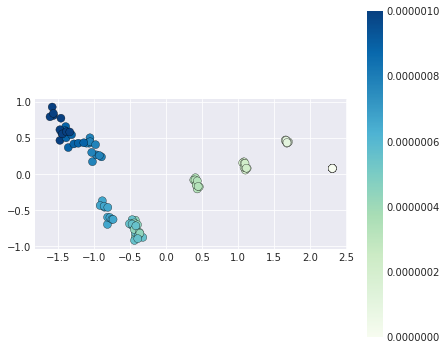

In [31]:
sns.set_style('darkgrid')

labels = set(dp_maxs)
n_labels = len(labels)
cmap_id = 'GnBu'
cmap = sns.color_palette(cmap_id, n_labels)

#g = sns.FacetGrid(dsplot, size=5, hue='dp_max', palette=cmap)
#g.map(plt.scatter, 'PC1','PC2', cmap=cmap)
# for ax in g.axes.flat:
#     pass
sns.set_palette(cmap)
pts = plt.scatter(dsplot.PC1, dsplot.PC2, c=dsplot.dp_max, cmap=cmap_id, edgecolor='#000000', lw=0.3, s=64)
#sns.despine(offset=1, trim=True)

plt.colorbar(pts)
pts.axes.set_aspect('equal')
pts.axes.figure.set_size_inches(7,6)

In [32]:
df_mu_tot = df_result[['dp_max','mu_tot']].drop_duplicates()
df_mu_tot

,dp_max,mu_tot
0,0.000000e+00,5.346286
19850,1.111111e-07,5.393113
39700,2.222222e-07,5.434253
59550,3.333333e-07,5.467655
79400,4.444444e-07,5.499373
99250,5.555556e-07,5.529851
119100,6.666667e-07,5.558883
138950,7.777778e-07,5.585378
158800,8.888889e-07,5.611189
178650,1.000000e-06,5.636377


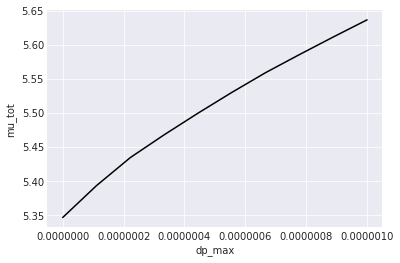

In [33]:
pts = plt.plot('dp_max','mu_tot', data=df_mu_tot, color='#000000')
ax = pts[0].axes
ax.set_xlabel('dp_max')
ax.set_ylabel('mu_tot')

## Growth rate validation

In [46]:
df_growth = df_result[['cond','dp_max','mu_tot','muk']].drop_duplicates()
df_growth = pd.merge(df_growth, df_XY[['cond','ex_rxn','substrate']].drop_duplicates(), on=['cond'])
df_growth.head(2)

,cond,dp_max,mu_tot,muk,ex_rxn,substrate
0,D-Glucose,0.000000e+00,5.346286,0.625090,EX_glc__D_e,glucose
1,D-Glucose,1.111111e-07,5.393113,0.636545,EX_glc__D_e,glucose


In [47]:
df_val = pd.merge(df_meas, df_growth, on=['substrate','ex_rxn'])
df_val.loc[:,'Measured'] = df_val.growth_rate_1_h
df_val.loc[:,'Simulated'] = df_val.muk
df_val.head()

,substrate,growth_rate_1_h,order,ex_rxn,cond,dp_max,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0.000000e+00,5.346286,0.625090,0.74,0.625090
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,1.111111e-07,5.393113,0.636545,0.74,0.636545
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,2.222222e-07,5.434253,0.643092,0.74,0.643092
3,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,3.333333e-07,5.467655,0.648276,0.74,0.648276
4,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,4.444444e-07,5.499373,0.654055,0.74,0.654055


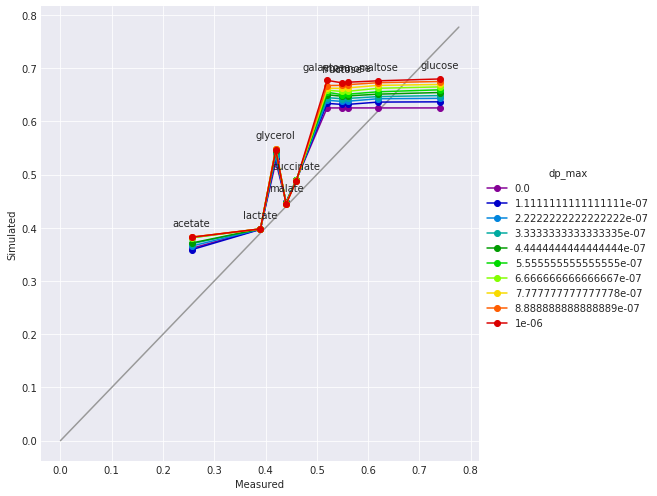

In [48]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

#colors = sns.color_palette('nipy_spectral')
cols = cmx.get_cmap('nipy_spectral')
cnorm = colors.Normalize(vmin=0, vmax=dp_maxs[-1])
cmap = cmx.ScalarMappable(norm=cnorm, cmap=cols)

g = sns.FacetGrid(size=7, data=df_val, hue='dp_max')
mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
plt.plot([0,mumax], [0,mumax], color='.6')

dp_maxs = df_val.dp_max.unique()
# for k,dp in enumerate(dp_maxs):
#     dfi = df_val[ df_val.dp_max==dp]
#     #plt.scatter()
#     cval = cmap.to_rgba(dp)
#     ls = plt.plot('Measured','Simulated', data=dfi, color=cval, alpha=1)
#     pts = plt.scatter('Measured','Simulated', data=dfi, alpha=1, s=12, c=cval)

sns.set_palette('nipy_spectral', len(dp_maxs))
g.map(plt.plot, 'Measured','Simulated', marker='o')

g.add_legend()

for k,subs in enumerate(df_val.substrate.unique()):
    dfi = df_val[ df_val.substrate==subs]    
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')

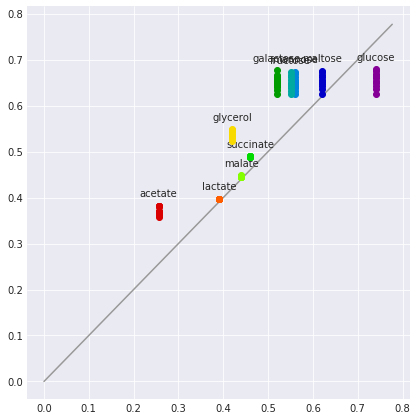

In [49]:
colors = sns.color_palette('nipy_spectral', len(df_val.substrate.unique()))
g = sns.FacetGrid(size=6, data=df_val)
mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
plt.plot([0,mumax], [0,mumax], color='.6')

for k,subs in enumerate(df_val.substrate.unique()):
    dfi = df_val[ df_val.substrate==subs]
    color = colors[k]
    plt.scatter('Measured','Simulated', data=dfi, zorder=4, c=color)
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')

## Proteomics validation

In [39]:
df_schmidt= pd.read_csv('/home/laurence/ME/data/cobrame/sectors/schmidt_prot_mf.csv')

In [40]:
df_schmidt.head(2)

,Gene,Bnumber,Annotated.functional.COG.groups..letter.,Annotated.functional.COG.group..description.,Annotated.functional.COG.class,Uniprot.Accession,condition,mf
0,rpoC,b3988,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8T7,Glucose,0.002941
1,rpoB,b3987,K,Transcription,INFORMATION STORAGE AND PROCESSING,P0A8V2,Glucose,0.004068


# Sample probabilities instead of dp_max

In [ ]:
n_conds = len(conds)

rows = []

In [88]:
N_SAMPLES = 40
mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'

#DP = 0.05
DP = 1e-7

for kk in range(N_SAMPLES):
    ps = np.random.uniform(size=n_conds)
    ps = ps / sum(ps)
    for k,(ind,mdli) in enumerate(iteritems(stacker.model_dict)):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
        rxn_mu = stacker.model.reactions.get_by_id('%s_%s'%(mu_id,ind))
        rxn_mu.objective_coefficient = ps[k]
            
    %time stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9) #, lp_method='barrier')
    
    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for k,ind in enumerate(stacker.model_dict.keys()):
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows.append(
                    {'dp_max':DP, 'prob':ps[k], 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows.append({'dp_max':DP, 'prob':np.nan, 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

CPU times: user 48.7 s, sys: 355 ms, total: 49.1 s
Wall time: 49.7 s
CPU times: user 57.6 s, sys: 56.3 ms, total: 57.6 s
Wall time: 57.8 s
CPU times: user 1min 25s, sys: 49.7 ms, total: 1min 25s
Wall time: 1min 25s
CPU times: user 1min 6s, sys: 37.7 ms, total: 1min 6s
Wall time: 1min 6s
CPU times: user 54.4 s, sys: 45.3 ms, total: 54.4 s
Wall time: 54.5 s
CPU times: user 1min 28s, sys: 49.7 ms, total: 1min 28s
Wall time: 1min 28s
CPU times: user 53.4 s, sys: 58.6 ms, total: 53.5 s
Wall time: 53.6 s
CPU times: user 55.3 s, sys: 51.5 ms, total: 55.3 s
Wall time: 55.4 s
CPU times: user 55.5 s, sys: 56.6 ms, total: 55.6 s
Wall time: 55.7 s
CPU times: user 59.3 s, sys: 68.7 ms, total: 59.3 s
Wall time: 59.5 s
CPU times: user 54.1 s, sys: 40.4 ms, total: 54.2 s
Wall time: 54.3 s
CPU times: user 43.5 s, sys: 41.6 ms, total: 43.5 s
Wall time: 43.7 s
CPU times: user 53.7 s, sys: 60.4 ms, total: 53.8 s
Wall time: 53.9 s
CPU times: user 34.7 s, sys: 54.9 ms, total: 34.8 s
Wall time: 34.8 s
CPU ti

In [112]:
len(rows)

992500

for k,row in enumerate(rows):
    if k>=10*m:
        row['sample'] = row['sample'] + 10

In [113]:
df_prob = pd.DataFrame(rows)

In [114]:
table = df_prob.pivot_table(index=['cond','sample'], columns='protein', values='ek')

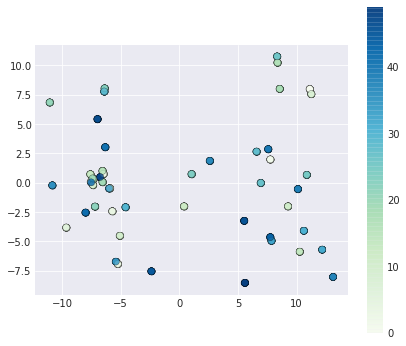

In [115]:
Z_AXIS = 1   # Z-score'd proteome for each cond
pca = PCA()
X = table.values
Z = preprocessing.scale(X, axis=Z_AXIS)

Z_new = pca.fit_transform(Z)
probs = [ix[1] for ix in table.index]
dsplot = pd.DataFrame.from_dict({'PC1':Z_new[:,0], 'PC2':Z_new[:,1], 'sample':probs})

sns.set_style('darkgrid')

labels = set(probs)
n_labels = len(labels)
cmap_id = 'GnBu'
cmap = sns.color_palette(cmap_id, n_labels)

sns.set_palette(cmap)
pts = plt.scatter(dsplot.PC1, dsplot.PC2, c=dsplot['sample'], cmap=cmap_id, edgecolor='#000000',
                  lw=0.3, s=49, alpha=0.8)

plt.colorbar(pts)
pts.axes.set_aspect('equal')
pts.axes.figure.set_size_inches(7,6)

In [116]:
df_growth2 = df_prob[['cond','sample','mu_tot','muk']].drop_duplicates()
df_growth2 = pd.merge(df_growth2, df_XY[['cond','ex_rxn','substrate']].drop_duplicates(), on='cond')

df_val2 = pd.merge(df_meas, df_growth2, on=['substrate','ex_rxn'])
df_val2.loc[:,'Measured'] = df_val2.growth_rate_1_h
df_val2.loc[:,'Simulated'] = df_val2.muk
df_val2.head()

,substrate,growth_rate_1_h,order,ex_rxn,cond,sample,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,0,0.562121,0.765919,0.74,0.765919
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,1,0.591494,0.702300,0.74,0.702300
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,2,0.538171,0.630137,0.74,0.630137
3,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,3,0.591746,0.708219,0.74,0.708219
4,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,4,0.506895,0.652790,0.74,0.652790


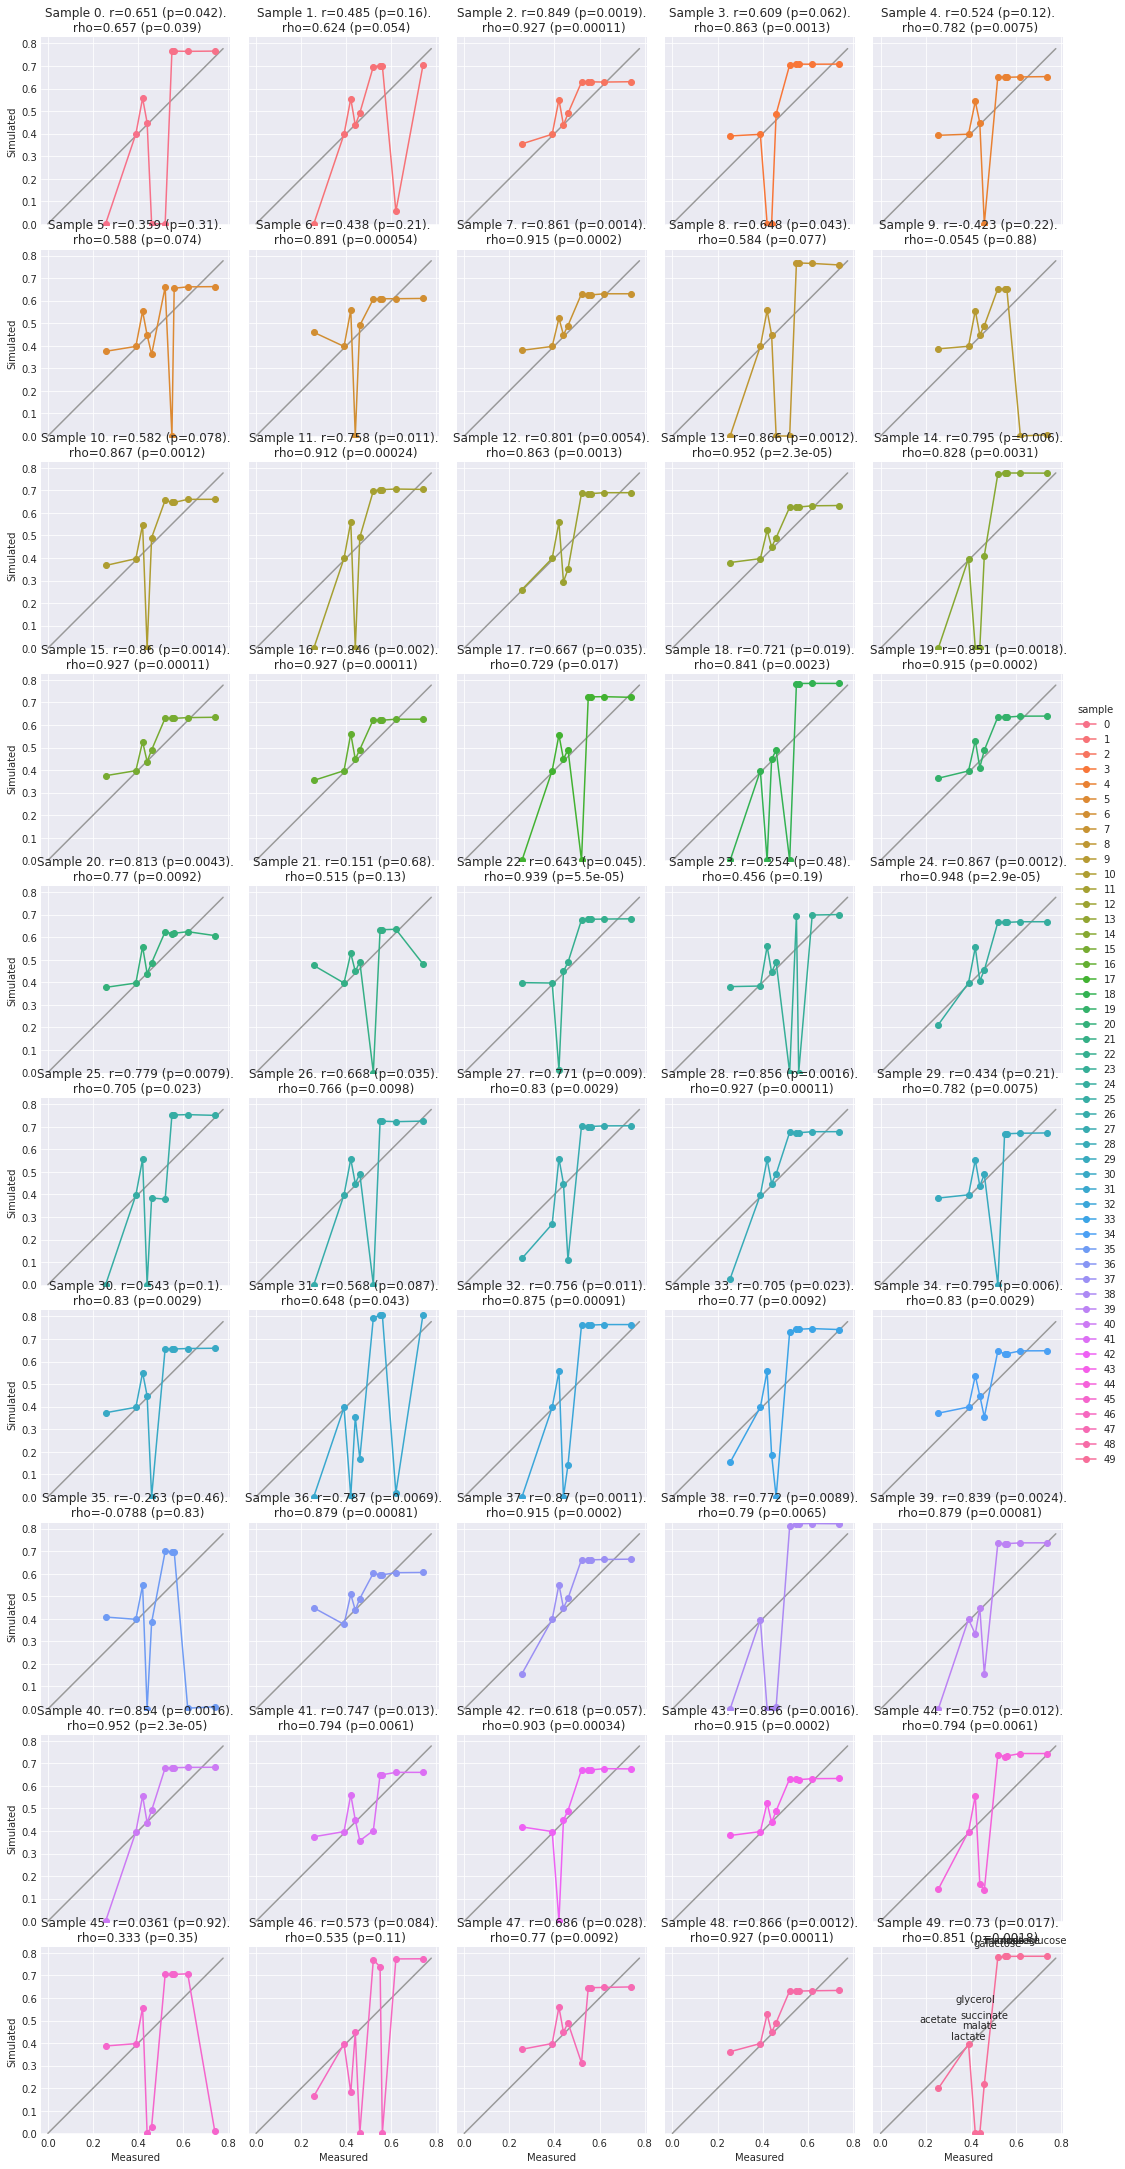

In [118]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy.stats as stats

g = sns.FacetGrid(size=3, data=df_val2, hue='sample', col='sample', col_wrap=5)
sns.set_palette('nipy_spectral', len(dp_maxs))

mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
for ax in g.axes.flat:
    ax.plot([0,mumax], [0,mumax], color='.6')
    ax.set_aspect('equal')

dp_maxs = df_val.dp_max.unique()

g.map(plt.plot, 'Measured','Simulated', marker='o')
#g.map(plt.plot, 'Measured','Simulated', marker='o', linestyle='None')


for ax in g.axes.flat:
    kk = int(ax.get_title().replace('sample = ',''))
    dfi = df_val2[ df_val2['sample']==kk]
    r,p = stats.pearsonr(dfi.Measured, dfi.Simulated)
    rho,p_rho = stats.spearmanr(dfi.Measured, dfi.Simulated)
    ax.set_title('Sample %s. r=%.3g (p=%.2g).\n rho=%.3g (p=%.2g)' % (
        kk,r,p,rho,p_rho
    ))

g.add_legend()

for k,subs in enumerate(df_val2.substrate.unique()):
    dfi = df_val2[ df_val2.substrate==subs]    
    smax = dfi.Simulated.max()
    x = dfi.Measured.mean()
    y = smax + 0.02
    plt.text(x,y, subs, ha='center')

In [127]:
df_y = df_val[['substrate','Measured','ex_rxn','cond']].drop_duplicates()
df_y.index = df_y.cond
df_y

,substrate,Measured,ex_rxn,cond
cond,,,,
D-Glucose,glucose,0.740,EX_glc__D_e,D-Glucose
Maltose,maltose,0.620,EX_malt_e,Maltose
D-Mannose,mannose,0.560,EX_man_e,D-Mannose
D-Fructose,fructose,0.550,EX_fru_e,D-Fructose
D-Galactose,galactose,0.520,EX_gal_e,D-Galactose
Succinate,succinate,0.460,EX_succ_e,Succinate
L-Malate,malate,0.440,EX_mal__L_e,L-Malate
Glycerol,glycerol,0.420,EX_glyc_e,Glycerol
L-Lactate,lactate,0.390,EX_lac__L_e,L-Lactate


In [140]:
mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'

#DP = 0.05
#DP = 1e-7

rows1 = []

for DP in [0., 1e-7, 1.]:
    for k,(ind,mdli) in enumerate(iteritems(stacker.model_dict)):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
        rxn_mu = stacker.model.reactions.get_by_id('%s_%s'%(mu_id,ind))
        mu_meask = df_y.loc[ind]['Measured']
        #pk = 1./mu_meask
        pk = mu_meask
        rxn_mu.objective_coefficient = pk

    %time stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9) #, lp_method='barrier')

    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for k,ind in enumerate(stacker.model_dict.keys()):
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows1.append(
                    {'dp_max':DP, 'prob':ps[k], 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows1.append({'dp_max':DP, 'prob':np.nan, 'sample':kk,
                     'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

CPU times: user 16.1 s, sys: 33.1 ms, total: 16.1 s
Wall time: 16.1 s
CPU times: user 1min, sys: 21.3 ms, total: 1min
Wall time: 1min
CPU times: user 3.89 s, sys: 17.6 ms, total: 3.9 s
Wall time: 3.86 s


In [143]:
df_1 = pd.DataFrame(rows1)

df_growth1 = df_1[['cond','sample','dp_max','mu_tot','muk']].drop_duplicates()
df_growth1 = pd.merge(df_growth1, df_XY[['cond','ex_rxn','substrate']].drop_duplicates(), on='cond')

df_val1 = pd.merge(df_meas, df_growth1, on=['substrate','ex_rxn'])
df_val1.loc[:,'Measured'] = df_val1.growth_rate_1_h
df_val1.loc[:,'Simulated'] = df_val1.muk
df_val1.head()

,substrate,growth_rate_1_h,order,ex_rxn,cond,sample,dp_max,mu_tot,muk,Measured,Simulated
0,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,49,0.000000e+00,2.825292,0.681572,0.74,0.681572
1,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,49,1.000000e-07,2.844479,0.689013,0.74,0.689013
2,glucose,0.74,0.0,EX_glc__D_e,D-Glucose,49,1.000000e+00,3.835461,0.980774,0.74,0.980774
3,maltose,0.62,3.0,EX_malt_e,Maltose,49,0.000000e+00,2.825292,0.681572,0.62,0.681572
4,maltose,0.62,3.0,EX_malt_e,Maltose,49,1.000000e-07,2.844479,0.688757,0.62,0.688757


In [147]:
df_val1.dp_max.unique()

array([0.e+00, 1.e-07, 1.e+00])

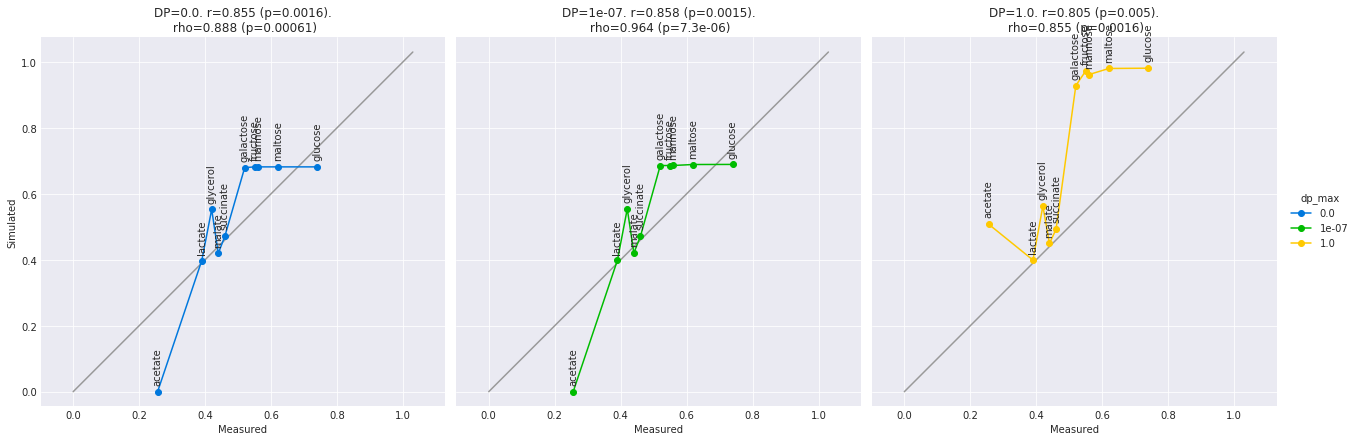

In [159]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy.stats as stats

g = sns.FacetGrid(size=6, data=df_val1, hue='dp_max', col='dp_max') #, col_wrap=5)
sns.set_palette('nipy_spectral', len(df_val1['dp_max'].unique()))

mumax = max(df_val1.Measured.max(), df_val1.Simulated.max())*1.05
for ax in g.axes.flat:
    ax.plot([0,mumax], [0,mumax], color='.6')
    ax.set_aspect('equal')

g.map(plt.plot, 'Measured','Simulated', marker='o')
#g.map(plt.plot, 'Measured','Simulated', marker='o', linestyle='None')

for ax in g.axes.flat:
    kk = float(ax.get_title().replace('dp_max = ',''))
    dfi = df_val1[ df_val1['dp_max']==kk]
    r,p = stats.pearsonr(dfi.Measured, dfi.Simulated)
    rho,p_rho = stats.spearmanr(dfi.Measured, dfi.Simulated)
    ax.set_title('DP=%s. r=%.3g (p=%.2g).\n rho=%.3g (p=%.2g)' % (
        kk,r,p,rho,p_rho
    ))

    for k,subs in enumerate(df_val1.substrate.unique()):
        dfj = dfi[ dfi.substrate==subs]    
        smax = dfj.Simulated.max()
        x = dfj.Measured.mean()
        y = smax + 0.02
        ax.text(x,y, subs, ha='center', rotation=90, va='bottom')
    
g.add_legend()

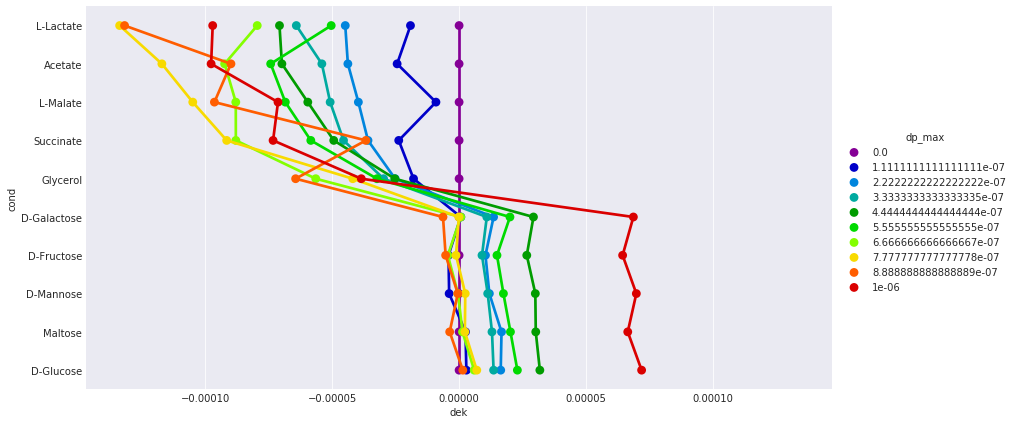

In [181]:
df_net = df_result.groupby(['cond','dp_max']).dek.sum().reset_index()
df_net.head()
sns.set_palette('nipy_spectral', len(df_net.dp_max.unique()))
g = sns.factorplot('dek','cond', data=df_net.sort_values('dek'), hue='dp_max', size=6, aspect=2, lw=0.25, alpha=0.75)
xmax = max(abs(df_net.dek))*1.1
g.set(xlim=[-xmax,xmax])

In [178]:
df_prob.head(2)

,cond,dek,dp_max,e0,ek,mu_tot,muk,prob,protein,sample,stat
0,D-Glucose,0.0,1.000000e-07,0.0,0.0,0.562121,0.765919,0.122357,e_12DGR120tipp,0,optimal
1,Acetate,0.0,1.000000e-07,0.0,0.0,0.562121,0.000131,0.039397,e_12DGR120tipp,0,optimal


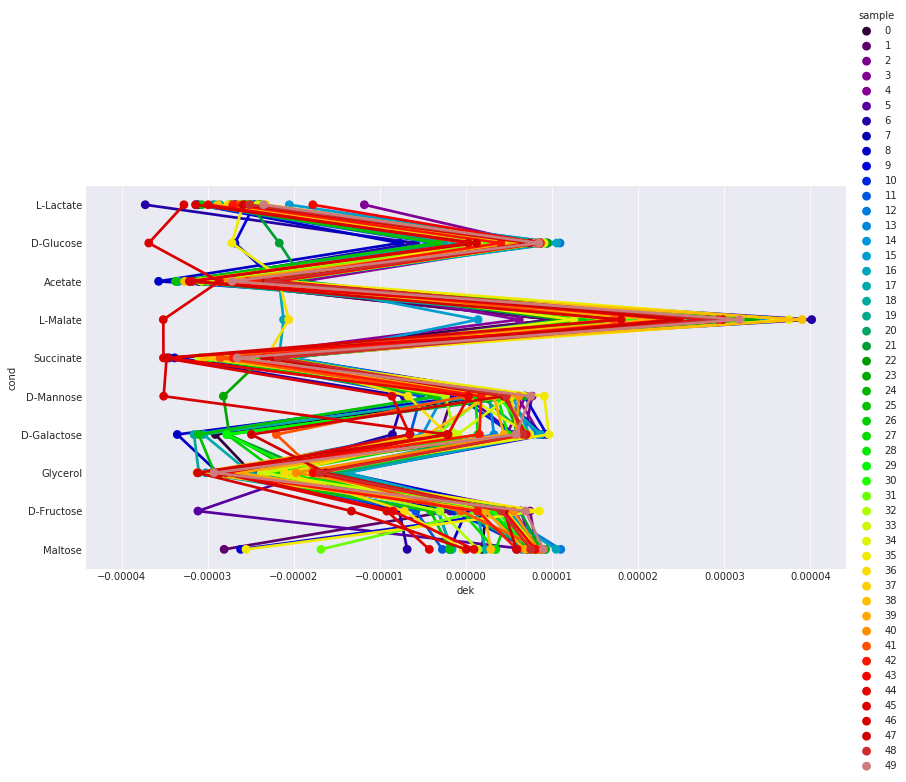

In [179]:
df_net = df_prob.groupby(['cond','sample']).dek.sum().reset_index()
sns.set_palette('nipy_spectral', len(df_net['sample'].unique()))
g = sns.factorplot('dek','cond', data=df_net.sort_values('dek'), hue='sample', size=6, aspect=2, lw=0.25, alpha=0.75)
xmax = max(abs(df_net.dek))*1.1
g.set(xlim=[-xmax,xmax])